# Imports

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, TensorDataset

from sklearn.utils.class_weight import compute_class_weight

from pypfopt import HRPOpt
import matplotlib.pyplot as plt
from skorch import NeuralNetClassifier
from scipy.stats import ttest_rel
import matplotlib.dates as mdates
from sklearn.metrics import f1_score

# Loading Data and Seperating Feature/Target 

In [3]:

# Load the data
file_name = "top_100_sp500_stock_data.csv"
#file_name = "top_7_sp500_stock_data.csv" # Used for testing models first
all_stocks_data = pd.read_csv(file_name)

# Create the target variable
all_stocks_data['Return_90d'] = (
    all_stocks_data.groupby('Ticker')['Close'].shift(-90) / all_stocks_data['Close'] - 1
)

# Modify the target variable to have labels 0 and 1
all_stocks_data['Target'] = (all_stocks_data['Return_90d'] > 0).astype(int)

In [4]:
# Drop rows with NaN values
all_stocks_data.dropna(inplace=True)

# Select features
feature_columns = [
    col for col in all_stocks_data.columns if col not in ['Ticker', 'Return_90d', 'Target', 'Date']
]
X = all_stocks_data[feature_columns]
y = all_stocks_data['Target']

# Handle infinity values
X = X.replace([np.inf, -np.inf], np.nan)

# Remove rows with NaN values
X = X.dropna()
y = y.loc[X.index]  


# Set up Random Search Parameters

In [6]:

# Define the parameter grid
param_dist = {
    'n_estimators': [10, 50, 100],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5]
}

# Initialize variables
start_year = 2014
end_year = 2022
yearly_results = []
trained_models = []

# Define feature columns
feature_columns = [
    col for col in all_stocks_data.columns if col not in ['Ticker', 'Return_90d', 'Target', 'Date']
]

# Initialize MinMaxScaler
scaler = MinMaxScaler()

for year in range(start_year, end_year + 1):
    print(f"\nProcessing year {year}...")
    
    # Filter data for the current year
    yearly_data = all_stocks_data[
        (all_stocks_data['Date'] >= f"{year}-01-01") & 
        (all_stocks_data['Date'] <= f"{year}-12-31")
    ]

    # Skip the year if no data is available
    if yearly_data.empty:
        print(f"No data available for year {year}. Skipping...")
        continue

    # Select features and target for the year
    X_year = yearly_data[feature_columns]
    y_year = yearly_data['Target']

    # Handle missing or infinity values
    X_year = X_year.replace([np.inf, -np.inf], np.nan).dropna()
    y_year = y_year.loc[X_year.index]

    # Skip if the filtered X_year is empty
    if X_year.empty:
        print(f"No valid data for year {year} after filtering. Skipping...")
        continue

    # Reset indices of both X_year and y_year for alignment
    X_year = X_year.reset_index(drop=True)
    y_year = y_year.reset_index(drop=True)

    # Normalize the features using the scaler
    X_year_scaled = scaler.fit_transform(X_year)

    # Split the data into Training (60%) and Temp (40%) sets
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_year_scaled, y_year, test_size=0.4, random_state=42, stratify=y_year
    )

    # Split Temp set into Validation (20%) and Test (20%) sets
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    # Debugging: Check data splits
    print(f"Training Set Size: {X_train.shape[0]} samples")
    print(f"Validation Set Size: {X_val.shape[0]} samples")
    print(f"Testing Set Size: {X_test.shape[0]} samples")

    # Instantiate the XGBClassifier
    xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')

    # Set up Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # RandomizedSearchCV with `cv=skf`
    random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_dist,
        n_iter=50,
        scoring='accuracy',
        cv=skf,
        verbose=2,
        random_state=42,
        n_jobs=4
    )

    # Perform the random search (This is done on training data)
    random_search.fit(X_train, y_train)

    # Get the best model from the random search
    best_xgb_model = random_search.best_estimator_

    # Print the best hyperparameters
    print(f"Best Hyperparameters for {year}:", random_search.best_params_)

    # Store the trained model and yearly data for evaluation
    trained_models.append((best_xgb_model, random_search.best_params_))
    yearly_results.append((X_year_scaled, y_year, yearly_data.reset_index(drop=True)))

    print(f"Year {year} processing completed.")



Processing year 2014...
Training Set Size: 12019 samples
Validation Set Size: 4007 samples
Testing Set Size: 4007 samples
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters for 2014: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.8}
Year 2014 processing completed.

Processing year 2015...
Training Set Size: 14589 samples
Validation Set Size: 4863 samples
Testing Set Size: 4864 samples
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters for 2015: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.8}
Year 2015 processing completed.

Processing year 2016...
Training Set Size: 14666 samples
Validation Set Size: 4889 samples
Testing Set Size: 4889 samples
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters for 2016: {'subs

# Make an XGBoost Classifier with the best parameters

In [7]:

# Initialize a dictionary to store models and F1-scores for each year
yearly_models = {}
f1_scores_xgb_per_year = {}

# Function to evaluate and print metrics while saving F1-scores
def evaluate_model(model, X, y, dataset_name, year):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')  # Calculate F1-score
    print(f"\n{dataset_name} Accuracy: {accuracy:.2f}")
    print(f"{dataset_name} F1-Score: {f1:.4f}")
    print(f"{dataset_name} Classification Report:")
    print(classification_report(y, y_pred))
    print(f"{dataset_name} Confusion Matrix:")
    print(confusion_matrix(y, y_pred))

    # Save F1-scores for the test set only
    if "Test Set" in dataset_name:
        f1_scores_xgb_per_year[year] = f1

# Loop through each year and train/evaluate the model
for year, (X_year_scaled, y_year, yearly_data) in zip(range(start_year, end_year + 1), yearly_results):
    print(f"\nTraining and evaluating XGBoost model for year {year}...")

    # Retrieve best hyperparameters for the year
    best_params = trained_models[year - start_year][1]

    # Create a new XGBoost classifier with the best parameters
    xgb_model = XGBClassifier(**best_params, random_state=42, eval_metric='logloss')

    # Split the yearly data into training, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_year_scaled, y_year, test_size=0.4, random_state=42, stratify=y_year
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    # Train the XGBoost classifier
    xgb_model.fit(X_train, y_train)

    # Evaluate the model on training, validation, and test sets
    evaluate_model(xgb_model, X_train, y_train, f"Year {year} - Training Set", year)
    evaluate_model(xgb_model, X_val, y_val, f"Year {year} - Validation Set", year)
    evaluate_model(xgb_model, X_test, y_test, f"Year {year} - Test Set", year)

    # Store the trained model for the year
    yearly_models[year] = xgb_model

# Print the saved F1-scores
print("\nF1-Scores for XGBoost across all years (Test Set):")
for year, f1_score in f1_scores_xgb_per_year.items():
    print(f"Year {year}: F1-Score = {f1_score:.4f}")

print("\nAll yearly models have been trained, evaluated, and F1-scores saved.")



Training and evaluating XGBoost model for year 2014...

Year 2014 - Training Set Accuracy: 1.00
Year 2014 - Training Set F1-Score: 1.0000
Year 2014 - Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3696
           1       1.00      1.00      1.00      8323

    accuracy                           1.00     12019
   macro avg       1.00      1.00      1.00     12019
weighted avg       1.00      1.00      1.00     12019

Year 2014 - Training Set Confusion Matrix:
[[3696    0]
 [   0 8323]]

Year 2014 - Validation Set Accuracy: 0.83
Year 2014 - Validation Set F1-Score: 0.8236
Year 2014 - Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.57      0.68      1232
           1       0.83      0.95      0.89      2775

    accuracy                           0.83      4007
   macro avg       0.84      0.76      0.78      4007
weighte

# Stock Ranking Using The Model

In [8]:
# Initialize a dictionary to store ranked stocks for each year
yearly_ranked_stocks = {}

for year, (X_year_scaled, y_year, yearly_data) in zip(range(start_year, end_year + 1), yearly_results):
    print(f"\nRanking stocks for year {year}...")

    # Get the trained model for the year
    xgb_model = yearly_models[year]

    # Extract tickers and scaled features for the current year
    tickers = yearly_data['Ticker']

    # Ensure tickers align with the scaled features
    tickers = tickers.iloc[:X_year_scaled.shape[0]]

    # Debugging: Check the lengths again
    print(f"Number of tickers (aligned): {len(tickers)}")
    print(f"Number of features (scaled): {X_year_scaled.shape[0]}")

    # Make predictions using the XGBoost model
    probabilities = xgb_model.predict_proba(X_year_scaled)[:, 1]

    # Debugging: Check the length of probabilities
    print(f"Number of probabilities: {len(probabilities)}")

    # Create a DataFrame with tickers and their corresponding probabilities
    ranked_stocks = pd.DataFrame({
        'Ticker': tickers.values,  # Use .values to align with probabilities
        'Probability_of_Positive_Return': probabilities
    })

    # Aggregate the probabilities by ticker using the mean
    ranked_stocks = ranked_stocks.groupby('Ticker', as_index=False)['Probability_of_Positive_Return'].mean()

    # Sort the stocks by mean probability in descending order
    ranked_stocks = ranked_stocks.sort_values(by='Probability_of_Positive_Return', ascending=False).reset_index(drop=True)

    # Store the ranked stocks for the year
    yearly_ranked_stocks[year] = ranked_stocks

    # Display the top-ranked stocks for the year
    print(f"Top 5 ranked stocks for {year}:")
    print(ranked_stocks.head())

print("\nAll yearly rankings have been generated.")



Ranking stocks for year 2014...
Number of tickers (aligned): 20033
Number of features (scaled): 20033
Number of probabilities: 20033
Top 5 ranked stocks for 2014:
  Ticker  Probability_of_Positive_Return
0   AAPL                        0.991922
1   VRTX                        0.980438
2   AVGO                        0.977410
3    LLY                        0.976511
4   COST                        0.975215

Ranking stocks for year 2015...
Number of tickers (aligned): 24316
Number of features (scaled): 24316
Number of probabilities: 24316
Top 5 ranked stocks for 2015:
  Ticker  Probability_of_Positive_Return
0   META                        0.968640
1     FI                        0.932593
2    PGR                        0.865358
3   NVDA                        0.845917
4  GOOGL                        0.820313

Ranking stocks for year 2016...
Number of tickers (aligned): 24444
Number of features (scaled): 24444
Number of probabilities: 24444
Top 5 ranked stocks for 2016:
  Ticker  Probab

# Apply HRP to Top n Stocks and Build Portfolio

In [9]:
# Initialize a dictionary to store adjusted HRP weights for each year
yearly_adjusted_weights = {}

for year, ranked_stocks in yearly_ranked_stocks.items():
    print(f"\nApplying HRP for year {year}...")

    # Filter the all_stocks_data for the selected tickers and date range
    tickers = ranked_stocks['Ticker']
    filtered_data = all_stocks_data[all_stocks_data['Ticker'].isin(tickers)]

    # Pivot to get price data for the tickers
    price_data = filtered_data.pivot(index='Date', columns='Ticker', values='Close')

    # Debugging: Check initial price data
    print(f"Price data for {year} (before cleaning):")
    print(price_data.head())

    # Handle missing data
    if price_data.isnull().any().any():
        print(f"Missing values found in price data for {year}. Handling them...")
        # Option 1: Drop rows with missing values
        # price_data.dropna(inplace=True)

        # Option 2: Fill missing values (forward-fill and backward-fill)
        price_data = price_data.ffill().bfill()

    # Debugging: Check cleaned price data
    print(f"Price data for {year} (after cleaning):")
    print(price_data.head())

    # Calculate daily returns
    returns = price_data.pct_change().dropna()

    # Apply the HRP algorithm using PyPortfolioOpt
    hrp = HRPOpt(returns)
    hrp_weights = hrp.optimize()

    # Convert weights to DataFrame
    hrp_weights_df = pd.DataFrame.from_dict(hrp_weights, orient='index', columns=['Weight'])
    hrp_weights_df.index.name = 'Ticker'
    hrp_weights_df.sort_values(by='Weight', ascending=False, inplace=True)

    print("\nHRP Weights without Probability Adjustment:")
    print(hrp_weights_df.head())

    # Adjust the HRP weights using predicted probabilities
    probabilities = ranked_stocks.set_index('Ticker')['Probability_of_Positive_Return']

    # Align the probabilities with the HRP weights
    aligned_probabilities = probabilities.reindex(hrp_weights_df.index)

    # Handle any missing values (drop tickers with missing probabilities)
    aligned_probabilities.dropna(inplace=True)
    hrp_weights_df = hrp_weights_df.loc[aligned_probabilities.index]

    # Multiply HRP weights by probabilities
    adjusted_weights = hrp_weights_df['Weight'] * aligned_probabilities

    # Normalize the adjusted weights so they sum to 1
    adjusted_weights /= adjusted_weights.sum()

    # Create a DataFrame for the adjusted weights
    adjusted_weights_df = adjusted_weights.to_frame('Adjusted Weight')
    adjusted_weights_df.index.name = 'Ticker'
    adjusted_weights_df.sort_values(by='Adjusted Weight', ascending=False, inplace=True)

    # Store the adjusted weights for the year
    yearly_adjusted_weights[year] = adjusted_weights_df

    print(f"\nHRP Weights Adjusted with Predicted Probabilities for {year}:")
    print(adjusted_weights_df.head())

print("\nHRP-adjusted weights for all years have been calculated.")



Applying HRP for year 2014...
Price data for 2014 (before cleaning):
Ticker                          AAPL       ABBV        ABT        ACN  \
Date                                                                    
2014-03-06 00:00:00+00:00  18.955357  52.040001  39.730000  83.800003   
2014-03-07 00:00:00+00:00  18.944286  51.459999  39.570000  83.930000   
2014-03-10 00:00:00+00:00  18.961430  51.660000  39.820000  84.040001   
2014-03-11 00:00:00+00:00  19.146070  51.750000  39.709999  83.550003   
2014-03-12 00:00:00+00:00  19.164642  51.639999  39.660000  82.750000   

Ticker                          ADBE        ADI        ADP       AMAT   AMD  \
Date                                                                          
2014-03-06 00:00:00+00:00  68.919998  51.570000  68.507462  19.379999  3.73   
2014-03-07 00:00:00+00:00  68.519997  51.830002  68.972786  19.639999  3.95   
2014-03-10 00:00:00+00:00  68.040001  51.799999  68.665497  19.379999  3.81   
2014-03-11 00:00:00+00:

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



HRP Weights without Probability Adjustment:
          Weight
Ticker          
VZ      0.033279
COST    0.022580
PFE     0.022266
T       0.022014
BMY     0.018832

HRP Weights Adjusted with Predicted Probabilities for 2014:
        Adjusted Weight
Ticker                 
COST           0.030744
VZ             0.028359
ADP            0.023693
BMY            0.022794
LMT            0.020602

Applying HRP for year 2015...
Price data for 2015 (before cleaning):
Ticker                          AAPL       ABBV        ABT        ACN  \
Date                                                                    
2014-03-06 00:00:00+00:00  18.955357  52.040001  39.730000  83.800003   
2014-03-07 00:00:00+00:00  18.944286  51.459999  39.570000  83.930000   
2014-03-10 00:00:00+00:00  18.961430  51.660000  39.820000  84.040001   
2014-03-11 00:00:00+00:00  19.146070  51.750000  39.709999  83.550003   
2014-03-12 00:00:00+00:00  19.164642  51.639999  39.660000  82.750000   

Ticker                   

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



HRP Weights without Probability Adjustment:
          Weight
Ticker          
VZ      0.033279
COST    0.022580
PFE     0.022266
T       0.022014
BMY     0.018832

HRP Weights Adjusted with Predicted Probabilities for 2015:
        Adjusted Weight
Ticker                 
T              0.028402
VZ             0.027242
PM             0.025535
PGR            0.025364
LMT            0.024881

Applying HRP for year 2016...
Price data for 2016 (before cleaning):
Ticker                          AAPL       ABBV        ABT        ACN  \
Date                                                                    
2014-03-06 00:00:00+00:00  18.955357  52.040001  39.730000  83.800003   
2014-03-07 00:00:00+00:00  18.944286  51.459999  39.570000  83.930000   
2014-03-10 00:00:00+00:00  18.961430  51.660000  39.820000  84.040001   
2014-03-11 00:00:00+00:00  19.146070  51.750000  39.709999  83.550003   
2014-03-12 00:00:00+00:00  19.164642  51.639999  39.660000  82.750000   

Ticker                   

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



HRP Weights without Probability Adjustment:
          Weight
Ticker          
VZ      0.033279
COST    0.022580
PFE     0.022266
T       0.022014
BMY     0.018832

HRP Weights Adjusted with Predicted Probabilities for 2016:
        Adjusted Weight
Ticker                 
VZ             0.026424
COST           0.022465
T              0.021151
PFE            0.020095
ADP            0.018727

Applying HRP for year 2017...
Price data for 2017 (before cleaning):
Ticker                          AAPL       ABBV        ABT        ACN  \
Date                                                                    
2014-03-06 00:00:00+00:00  18.955357  52.040001  39.730000  83.800003   
2014-03-07 00:00:00+00:00  18.944286  51.459999  39.570000  83.930000   
2014-03-10 00:00:00+00:00  18.961430  51.660000  39.820000  84.040001   
2014-03-11 00:00:00+00:00  19.146070  51.750000  39.709999  83.550003   
2014-03-12 00:00:00+00:00  19.164642  51.639999  39.660000  82.750000   

Ticker                   

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



HRP Weights without Probability Adjustment:
          Weight
Ticker          
VZ      0.033279
COST    0.022580
PFE     0.022266
T       0.022014
BMY     0.018832

HRP Weights Adjusted with Predicted Probabilities for 2017:
        Adjusted Weight
Ticker                 
VZ             0.027641
ADP            0.020491
COST           0.020358
LMT            0.020356
PGR            0.019858

Applying HRP for year 2018...
Price data for 2018 (before cleaning):
Ticker                          AAPL       ABBV        ABT        ACN  \
Date                                                                    
2014-03-06 00:00:00+00:00  18.955357  52.040001  39.730000  83.800003   
2014-03-07 00:00:00+00:00  18.944286  51.459999  39.570000  83.930000   
2014-03-10 00:00:00+00:00  18.961430  51.660000  39.820000  84.040001   
2014-03-11 00:00:00+00:00  19.146070  51.750000  39.709999  83.550003   
2014-03-12 00:00:00+00:00  19.164642  51.639999  39.660000  82.750000   

Ticker                   

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683
 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683 0.58480683]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



HRP Weights without Probability Adjustment:
          Weight
Ticker          
VZ      0.033279
COST    0.022580
PFE     0.022266
T       0.022014
BMY     0.018832

HRP Weights Adjusted with Predicted Probabilities for 2018:
        Adjusted Weight
Ticker                 
VZ             0.035677
COST           0.026812
NEE            0.023499
PFE            0.022891
ADP            0.021034

Applying HRP for year 2019...
Price data for 2019 (before cleaning):
Ticker                          AAPL       ABBV        ABT        ACN  \
Date                                                                    
2014-03-06 00:00:00+00:00  18.955357  52.040001  39.730000  83.800003   
2014-03-07 00:00:00+00:00  18.944286  51.459999  39.570000  83.930000   
2014-03-10 00:00:00+00:00  18.961430  51.660000  39.820000  84.040001   
2014-03-11 00:00:00+00:00  19.146070  51.750000  39.709999  83.550003   
2014-03-12 00:00:00+00:00  19.164642  51.639999  39.660000  82.750000   

Ticker                   

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.58562282 0.58562282 0.58562282 0.58562282 0.58562282 0.58562282
 0.58562282 0.58562282 0.58562282 0.58562282 0.58562282 0.58562282
 0.58562282 0.58562282 0.58562282 0.58562282 0.58562282 0.58562282
 0.58562282 0.58562282 0.58562282 0.58562282 0.58562282 0.58562282
 0.58562282 0.58562282 0.58562282 0.58562282 0.58562282 0.58562282
 0.58562282 0.58562282 0.58562282 0.58562282 0.58562282 0.58562282
 0.58562282 0.58562282 0.58562282 0.58562282 0.58562282 0.58562282
 0.58562282 0.58562282 0.58562282 0.58562282 0.58562282 0.58562282
 0.58562282]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



HRP Weights without Probability Adjustment:
          Weight
Ticker          
VZ      0.025907
BMY     0.023555
T       0.023307
PGR     0.020960
ABBV    0.018442

HRP Weights Adjusted with Predicted Probabilities for 2019:
        Adjusted Weight
Ticker                 
T              0.028122
VZ             0.022969
BMY            0.022240
NEE            0.022078
PGR            0.021104

Applying HRP for year 2020...
Price data for 2020 (before cleaning):
Ticker                          AAPL       ABBV        ABT        ACN  \
Date                                                                    
2014-03-06 00:00:00+00:00  18.955357  52.040001  39.730000  83.800003   
2014-03-07 00:00:00+00:00  18.944286  51.459999  39.570000  83.930000   
2014-03-10 00:00:00+00:00  18.961430  51.660000  39.820000  84.040001   
2014-03-11 00:00:00+00:00  19.146070  51.750000  39.709999  83.550003   
2014-03-12 00:00:00+00:00  19.164642  51.639999  39.660000  82.750000   

Ticker                   

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.58562282 0.58562282 0.58562282 0.58562282 0.58562282 0.58562282
 0.58562282 0.58562282 0.58562282 0.58562282 0.58562282 0.58562282
 0.58562282 0.58562282 0.58562282 0.58562282 0.58562282 0.58562282
 0.58562282 0.58562282 0.58562282 0.58562282 0.58562282 0.58562282
 0.58562282 0.58562282 0.58562282 0.58562282 0.58562282 0.58562282
 0.58562282 0.58562282 0.58562282 0.58562282 0.58562282 0.58562282
 0.58562282 0.58562282 0.58562282 0.58562282 0.58562282 0.58562282
 0.58562282 0.58562282 0.58562282 0.58562282 0.58562282 0.58562282
 0.58562282]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



HRP Weights without Probability Adjustment:
          Weight
Ticker          
VZ      0.025907
BMY     0.023555
T       0.023307
PGR     0.020960
ABBV    0.018442

HRP Weights Adjusted with Predicted Probabilities for 2020:
        Adjusted Weight
Ticker                 
PGR            0.021720
UNH            0.020933
ABBV           0.020508
BMY            0.019517
TMUS           0.019309

Applying HRP for year 2021...
Price data for 2021 (before cleaning):
Ticker                          AAPL       ABBV        ABT        ACN  \
Date                                                                    
2014-03-06 00:00:00+00:00  18.955357  52.040001  39.730000  83.800003   
2014-03-07 00:00:00+00:00  18.944286  51.459999  39.570000  83.930000   
2014-03-10 00:00:00+00:00  18.961430  51.660000  39.820000  84.040001   
2014-03-11 00:00:00+00:00  19.146070  51.750000  39.709999  83.550003   
2014-03-12 00:00:00+00:00  19.164642  51.639999  39.660000  82.750000   

Ticker                   

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.59270273 0.59270273 0.59270273 0.59270273 0.59270273 0.59270273
 0.59270273 0.59270273 0.59270273 0.59270273 0.59270273 0.59270273
 0.59270273 0.59270273 0.59270273 0.59270273 0.59270273 0.59270273
 0.59270273 0.59270273 0.59270273 0.59270273 0.59270273 0.59270273
 0.59270273 0.59270273 0.59270273 0.59270273 0.59270273 0.59270273
 0.59270273 0.59270273 0.59270273 0.59270273 0.59270273 0.59270273
 0.59270273 0.59270273 0.59270273 0.59270273 0.59270273 0.59270273
 0.59270273 0.59270273 0.59270273 0.59270273 0.59270273 0.59270273
 0.59270273]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



HRP Weights without Probability Adjustment:
          Weight
Ticker          
VZ      0.029423
WMT     0.023695
MRK     0.022971
TMUS    0.021739
BMY     0.021698

HRP Weights Adjusted with Predicted Probabilities for 2021:
        Adjusted Weight
Ticker                 
PG             0.024493
MRK            0.024254
LLY            0.023677
COST           0.022255
PEP            0.021523

Applying HRP for year 2022...
Price data for 2022 (before cleaning):
Ticker                          AAPL       ABBV        ABT        ACN  \
Date                                                                    
2014-03-06 00:00:00+00:00  18.955357  52.040001  39.730000  83.800003   
2014-03-07 00:00:00+00:00  18.944286  51.459999  39.570000  83.930000   
2014-03-10 00:00:00+00:00  18.961430  51.660000  39.820000  84.040001   
2014-03-11 00:00:00+00:00  19.146070  51.750000  39.709999  83.550003   
2014-03-12 00:00:00+00:00  19.164642  51.639999  39.660000  82.750000   

Ticker                   

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.59270273 0.59270273 0.59270273 0.59270273 0.59270273 0.59270273
 0.59270273 0.59270273 0.59270273 0.59270273 0.59270273 0.59270273
 0.59270273 0.59270273 0.59270273 0.59270273 0.59270273 0.59270273
 0.59270273 0.59270273 0.59270273 0.59270273 0.59270273 0.59270273
 0.59270273 0.59270273 0.59270273 0.59270273 0.59270273 0.59270273
 0.59270273 0.59270273 0.59270273 0.59270273 0.59270273 0.59270273
 0.59270273 0.59270273 0.59270273 0.59270273 0.59270273 0.59270273
 0.59270273 0.59270273 0.59270273 0.59270273 0.59270273 0.59270273
 0.59270273]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



HRP Weights without Probability Adjustment:
          Weight
Ticker          
VZ      0.029423
WMT     0.023695
MRK     0.022971
TMUS    0.021739
BMY     0.021698

HRP Weights Adjusted with Predicted Probabilities for 2022:
        Adjusted Weight
Ticker                 
MRK            0.038870
TMUS           0.032302
PGR            0.027425
LLY            0.026660
BMY            0.025102

HRP-adjusted weights for all years have been calculated.


# Backtest Our Portfolio

Simulating portfolio for year 2014...
Missing data filled for year 2014. Final shape: (208, 97)
Simulating portfolio for year 2015...
Missing data filled for year 2015. Final shape: (251, 97)
Simulating portfolio for year 2016...
Missing data filled for year 2016. Final shape: (252, 97)
Simulating portfolio for year 2017...
Missing data filled for year 2017. Final shape: (251, 97)
Simulating portfolio for year 2018...
Missing data filled for year 2018. Final shape: (250, 97)
Simulating portfolio for year 2019...
Missing data filled for year 2019. Final shape: (251, 98)
Simulating portfolio for year 2020...
Missing data filled for year 2020. Final shape: (252, 98)
Simulating portfolio for year 2021...
Missing data filled for year 2021. Final shape: (251, 99)
Simulating portfolio for year 2022...
Missing data filled for year 2022. Final shape: (251, 99)


[*********************100%***********************]  1 of 1 completed


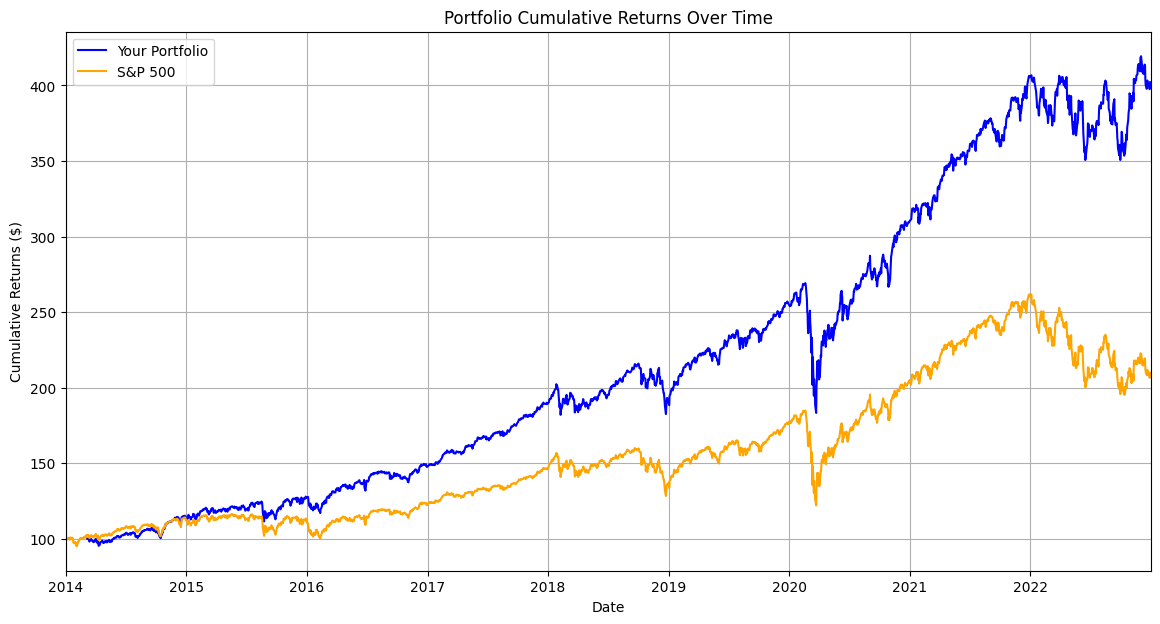

In [10]:
initial_investment = 100
portfolio_value = initial_investment
cumulative_portfolio_returns = []

for year, (ranked_stocks, adjusted_weights_df) in enumerate(yearly_adjusted_weights.items(), start=start_year):
    print(f"Simulating portfolio for year {year}...")
    
    # Filter the all_stocks_data for the selected tickers and date range
    tickers = adjusted_weights_df.index
    filtered_data = all_stocks_data[all_stocks_data['Ticker'].isin(tickers)]
    price_data_year = filtered_data.pivot(index='Date', columns='Ticker', values='Close')
    price_data_year = price_data_year.loc[f"{year}-01-01":f"{year}-12-31"]

    # Handle missing data by forward-filling and backward-filling
    price_data_year = price_data_year.ffill().bfill()

    # Debugging statement to ensure no NaN values remain
    if price_data_year.isna().any().any():
        print(f"Warning: Missing data still present for year {year}")
    else:
        print(f"Missing data filled for year {year}. Final shape: {price_data_year.shape}")

    # Calculate returns for the year's tickers
    returns_year = price_data_year.pct_change().dropna()

    # Ensure the returns DataFrame contains only the tickers in the portfolio
    portfolio_returns = returns_year[adjusted_weights_df.index]

    # Multiply the daily returns by the portfolio weights to get the weighted returns
    weighted_returns = portfolio_returns.mul(adjusted_weights_df['Adjusted Weight'], axis=1)

    # Sum the weighted returns across all assets to get the portfolio's daily return
    portfolio_daily_returns = weighted_returns.sum(axis=1)

    # Calculate the portfolio's daily cumulative returns
    yearly_cumulative_returns = (1 + portfolio_daily_returns).cumprod()

    # Scale the returns by the current portfolio value
    yearly_cumulative_returns *= portfolio_value

    # Update the portfolio value for the end of the year
    portfolio_value = yearly_cumulative_returns.iloc[-1]

    # Store cumulative returns for this year
    cumulative_portfolio_returns.append(yearly_cumulative_returns)

# Combine yearly returns into a single series
final_cumulative_returns = pd.concat(cumulative_portfolio_returns).sort_index()

# --------------------------------------------
# Step 6: Benchmark and Visualization
# --------------------------------------------
# Download historical price data for the S&P 500 index
sp500_data = yf.download('^GSPC', start=f"{start_year}-01-01", end=f"{end_year}-12-31")['Adj Close']
sp500_returns = sp500_data.pct_change().dropna()
sp500_cumulative_returns = (1 + sp500_returns).cumprod() * 100

# Align cumulative returns
sp500_cumulative_returns.index = pd.to_datetime(sp500_cumulative_returns.index)
final_cumulative_returns.index = pd.to_datetime(final_cumulative_returns.index)

# Plot cumulative returns
plt.figure(figsize=(14, 7))

# Plot the portfolio and S&P 500 cumulative returns
plt.plot(final_cumulative_returns.index, final_cumulative_returns, label='Your Portfolio', color='blue')
plt.plot(sp500_cumulative_returns.loc[f"{start_year}-01-01":f"{end_year}-12-31"].index,
         sp500_cumulative_returns.loc[f"{start_year}-01-01":f"{end_year}-12-31"].values,
         label='S&P 500', color='orange')

# Set plot details
plt.title('Portfolio Cumulative Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns ($)')
plt.legend()
plt.grid(True)

# Set x-axis to yearly intervals
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim(pd.Timestamp(f"{start_year}-01-01"), pd.Timestamp(f"{end_year}-12-31"))

plt.show()


# Comparing Results

In [11]:
# Function to compute performance metrics
def calculate_performance_metrics(returns_series, risk_free_rate=0.0):
    # Check if the series is empty
    if returns_series.empty:
        raise ValueError("The returns series is empty. Check your data and calculations.")

    # Calculate total return
    total_return = returns_series.iloc[-1] / returns_series.iloc[0] - 1

    # Calculate the number of years in the returns series
    num_years = (returns_series.index[-1] - returns_series.index[0]).days / 365.25

    # Calculate annualized return
    annualized_return = (1 + total_return) ** (1 / num_years) - 1

    # Calculate annualized volatility
    annualized_volatility = returns_series.pct_change().std() * np.sqrt(252)

    # Calculate Sharpe ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

    return {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio
    }

# Calculate metrics for the portfolio
portfolio_metrics = calculate_performance_metrics(final_cumulative_returns)

# Calculate metrics for the S&P 500
sp500_metrics = calculate_performance_metrics(sp500_cumulative_returns)

# Convert S&P 500 metrics into scalar values (remove index metadata)
sp500_metrics_cleaned = {key: float(value) for key, value in sp500_metrics.items()}

# Create a DataFrame with the metrics for comparison
metrics_df = pd.DataFrame(
    [portfolio_metrics, sp500_metrics_cleaned], 
    index=['Your Portfolio', 'S&P 500']
)

# Display the metrics
print("\nPortfolio vs. S&P 500 Performance Metrics:")
metrics_df



Portfolio vs. S&P 500 Performance Metrics:


C:\Users\Alec\AppData\Local\Temp\ipykernel_7312\2732809231.py:36: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sp500_metrics_cleaned = {key: float(value) for key, value in sp500_metrics.items()}


,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio
Your Portfolio,3.007700,0.170543,0.170018,1.003090
S&P 500,1.096518,0.085846,0.181824,0.472138


# LSTM 
### Doesn't use sequencing because each row has 30 lagged days

In [ ]:
# Initialize variables
initial_investment = 100
lstm_portfolio_value = initial_investment
lstm_cumulative_portfolio_returns = []
f1_scores_lstm_per_year = {}

# Define feature columns and target
feature_columns = [
    col for col in all_stocks_data.columns if col not in ['Ticker', 'Return_90d', 'Target', 'Date']
]

# --------------------------------------------
# Step 2: Define LSTM Model
# --------------------------------------------
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=2, output_size=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add time dimension
        lstm_out, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])  # Output from the last hidden layer
        return out

# --------------------------------------------
# Step 3: Hyperparameter Grid for RandomizedSearchCV
# --------------------------------------------
param_dist = {
    'module__hidden_size': [50, 100, 150],
    'module__num_layers': [1, 2, 3],
    'lr': [0.001, 0.005, 0.01],
    'iterator_train__batch_size': [16, 32, 64],
    'iterator_valid__batch_size': [16, 32, 64],
    'max_epochs': [25, 50],
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --------------------------------------------
# Step 4: Yearly Training and Portfolio Construction
# --------------------------------------------
for year in range(start_year, end_year + 1):
    print(f"\nProcessing year {year}...")

    # Filter data for the current year
    yearly_data = all_stocks_data[
        (all_stocks_data['Date'] >= f"{year}-01-01") &
        (all_stocks_data['Date'] <= f"{year}-12-31")
    ]

    if yearly_data.empty:
        print(f"No data available for year {year}. Skipping...")
        continue

    # Extract features and target
    X_year = yearly_data[feature_columns]
    y_year = yearly_data['Target']

    # Handle missing data
    X_year = X_year.replace([np.inf, -np.inf], np.nan).dropna()
    y_year = y_year.loc[X_year.index]
    if X_year.empty:
        print(f"No valid data for year {year}. Skipping...")
        continue

    # Normalize the features
    scaler = MinMaxScaler()
    X_year_scaled = scaler.fit_transform(X_year)

    # Split into training, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_year_scaled, y_year, test_size=0.4, random_state=42, stratify=y_year
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    # Wrap LSTM with Skorch for RandomizedSearchCV
    net = NeuralNetClassifier(
        module=LSTMModel,
        module__input_size=X_year_scaled.shape[1],
        module__hidden_size=50,
        module__num_layers=2,
        module__output_size=len(np.unique(y_year)),
        criterion=nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        train_split=None,
        verbose=0,
        device='cuda' if torch.cuda.is_available() else 'cpu',
    )

    # Perform RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=net,
        param_distributions=param_dist,
        n_iter=10,  # Adjust based on computational resources
        scoring='accuracy',
        cv=skf,
        verbose=2,
        random_state=42,
        n_jobs=-1
    )

    # Ensure target is integer type for skorch compatibility
    y_train = y_train.astype(int)
    random_search.fit(X_train.astype(np.float32), y_train)

    # Get the best model and hyperparameters
    best_lstm_model = random_search.best_estimator_
    print(f"\nBest Hyperparameters for {year}: {random_search.best_params_}")

    # Evaluate the model on the test set and save F1-score
    y_test_pred_lstm = best_lstm_model.predict(X_test.astype(np.float32))
    lstm_f1_score_test = f1_score(y_test, y_test_pred_lstm, average='weighted')  # Updated variable name
    f1_scores_lstm_per_year[year] = lstm_f1_score_test
    print(f"Year {year} - LSTM Test Set F1-Score: {lstm_f1_score_test:.4f}")

    # Predict probabilities for the current year's data
    probabilities_lstm = best_lstm_model.predict_proba(X_year_scaled.astype(np.float32))[:, 1]

    # Create a ranked stocks DataFrame
    ranked_stocks_lstm = pd.DataFrame({
        'Ticker': yearly_data['Ticker'].values,
        'Probability_of_Positive_Return': probabilities_lstm
    })
    ranked_stocks_lstm = ranked_stocks_lstm.groupby('Ticker', as_index=False)['Probability_of_Positive_Return'].mean()
    ranked_stocks_lstm = ranked_stocks_lstm.sort_values(by='Probability_of_Positive_Return', ascending=False)

    # Filter and prepare price data for HRP
    filtered_data_lstm = yearly_data[yearly_data['Ticker'].isin(ranked_stocks_lstm['Ticker'])]
    price_data_year_lstm = filtered_data_lstm.pivot(index='Date', columns='Ticker', values='Close').dropna()
    returns_year_lstm = price_data_year_lstm.pct_change().dropna()

    # Apply HRP
    hrp_lstm = HRPOpt(returns_year_lstm)
    hrp_weights_lstm = hrp_lstm.optimize()

    # Adjust HRP weights with probabilities
    hrp_weights_df_lstm = pd.DataFrame.from_dict(hrp_weights_lstm, orient='index', columns=['Weight'])
    hrp_weights_df_lstm.index.name = 'Ticker'
    probabilities_series_lstm = ranked_stocks_lstm.set_index('Ticker')['Probability_of_Positive_Return']
    aligned_probabilities_lstm = probabilities_series_lstm.reindex(hrp_weights_df_lstm.index).dropna()
    adjusted_weights_lstm = (hrp_weights_df_lstm['Weight'] * aligned_probabilities_lstm).div(
        (hrp_weights_df_lstm['Weight'] * aligned_probabilities_lstm).sum()
    )
    adjusted_weights_df_lstm = adjusted_weights_lstm.to_frame('Adjusted Weight')

    # Calculate the portfolio's daily returns
    portfolio_returns_lstm = returns_year_lstm[adjusted_weights_df_lstm.index].mul(
        adjusted_weights_df_lstm['Adjusted Weight'], axis=1
    ).sum(axis=1)

    # Calculate cumulative returns for the year
    lstm_yearly_cumulative_returns = (1 + portfolio_returns_lstm).cumprod() * lstm_portfolio_value

    # Update the portfolio value for the end of the year
    lstm_portfolio_value = lstm_yearly_cumulative_returns.iloc[-1]

    # Store cumulative returns for the year
    lstm_cumulative_portfolio_returns.append(lstm_yearly_cumulative_returns)

# Combine yearly returns into a single series
final_lstm_cumulative_returns = pd.concat(lstm_cumulative_portfolio_returns).sort_index()

# --------------------------------------------
# Step 5: Benchmark and Visualization
# --------------------------------------------
sp500_data = yf.download('^GSPC', start=f"{start_year}-01-01", end=f"{end_year}-12-31")['Adj Close']
sp500_cumulative_returns = (1 + sp500_data.pct_change().dropna()).cumprod() * initial_investment

# Ensure indices are DatetimeIndex
final_lstm_cumulative_returns.index = pd.to_datetime(final_lstm_cumulative_returns.index)
sp500_cumulative_returns.index = pd.to_datetime(sp500_cumulative_returns.index)

# Plot portfolio vs. S&P 500
plt.figure(figsize=(14, 7))
plt.plot(final_lstm_cumulative_returns, label='LSTM Portfolio')
plt.plot(sp500_cumulative_returns, label='S&P 500')
plt.title('LSTM Portfolio vs S&P 500 Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns ($)')
plt.legend()
plt.grid(True)
plt.show()

# Print the yearly F1-scores for LSTM
print("\nF1-Scores for LSTM across all years (Test Set):")
for year, f1 in f1_scores_lstm_per_year.items():
    print(f"Year {year}: F1-Score = {f1:.4f}")


Processing year 2014...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


# Evaluate XGBooster and LSTM Models 

In [ ]:
# Ensure F1-scores are converted to standard Python floats
f1_scores_lstm_per_year = [float(score) for score in f1_scores_lstm_per_year]
f1_scores_xgb_per_year = [float(score) for score in f1_scores_xgb_per_year]

# --------------------------------------------
# Perform Statistical Analysis
# --------------------------------------------

# Print the collected F1-scores
print(f"\nYearly LSTM F1-scores: {f1_scores_lstm_per_year}")
print(f"Yearly XGBoost F1-scores: {f1_scores_xgb_per_year}")

# Compute the mean and standard deviation of the F1-scores
print(f"LSTM F1-Score Mean: {np.mean(f1_scores_lstm_per_year):.4f}, Std Dev: {np.std(f1_scores_lstm_per_year):.4f}")
print(f"XGBoost F1-Score Mean: {np.mean(f1_scores_xgb_per_year):.4f}, Std Dev: {np.std(f1_scores_xgb_per_year):.4f}")

# Perform a paired t-test to compare the models' F1-scores across years
t_stat, p_value_t = ttest_rel(f1_scores_lstm_per_year, f1_scores_xgb_per_year)
print(f"\nPaired t-test: t-statistic = {t_stat:.4f}, p-value = {p_value_t:.4f}")



Yearly LSTM F1-scores: [0.914880915727608, 0.8945477372760411, 0.8286848262032085, 0.9024259363610947, 0.9213420588420589, 0.7787361891839503]
Yearly XGBoost F1-scores: [0.951360523272919, 0.9254489795918367, 0.9356425022583559, 0.9360721652020965, 0.9431818181818182, 0.9347494079551496]
LSTM F1-Score Mean: 0.8734, Std Dev: 0.0521
XGBoost F1-Score Mean: 0.9377, Std Dev: 0.0080

Paired t-test: t-statistic = -2.8891, p-value = 0.0342


# Comparing Performance of XGBoost LSTM and S&P500

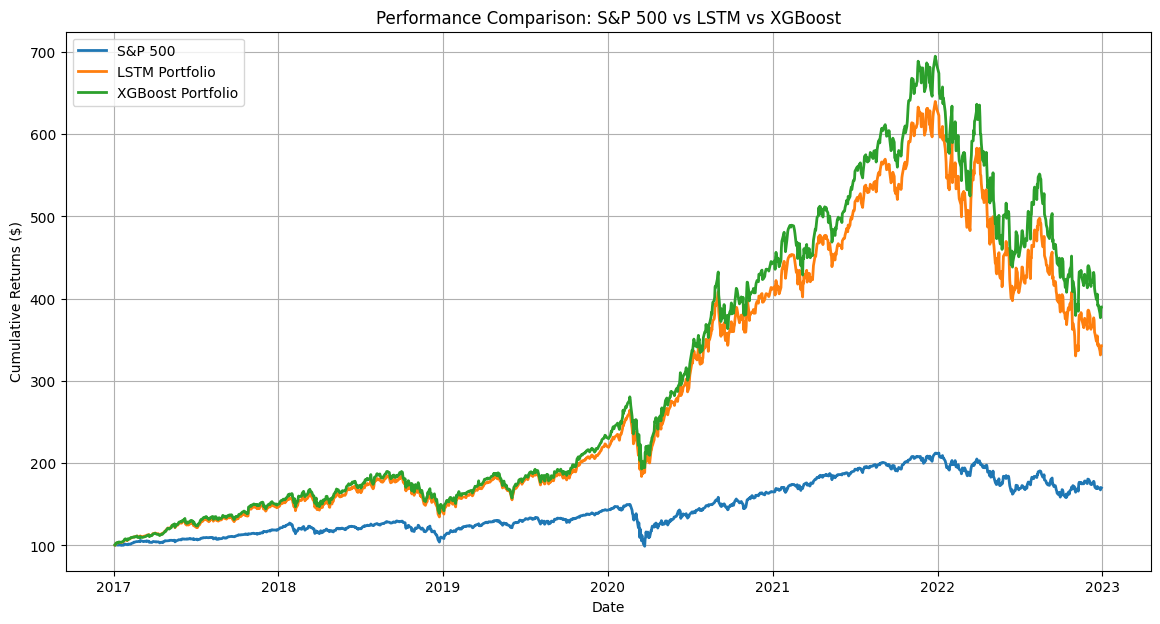

In [ ]:
# Ensure cumulative returns for XGBoost, LSTM, and S&P 500 are aligned
combined_data = pd.concat(
    [sp500_cumulative_returns, final_lstm_cumulative_returns, final_cumulative_returns],
    axis=1, 
    join='inner'
)
combined_data.columns = ['S&P 500', 'LSTM Portfolio', 'XGBoost Portfolio']

# Plot the performance over time
plt.figure(figsize=(14, 7))
plt.plot(combined_data.index, combined_data['S&P 500'], label='S&P 500', linewidth=2)
plt.plot(combined_data.index, combined_data['LSTM Portfolio'], label='LSTM Portfolio', linewidth=2)
plt.plot(combined_data.index, combined_data['XGBoost Portfolio'], label='XGBoost Portfolio', linewidth=2)

# Customize the plot
plt.title('Performance Comparison: S&P 500 vs LSTM vs XGBoost')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns ($)')
plt.legend(loc="upper left")
plt.grid(True)

# Show the plot
plt.show()
